In [3]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re # for regular expressions
import pandas as pd 
pd.set_option("display.max_colwidth", 200) 
import string
import nltk # for text manipulation
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
#from gensim.models.doc2vec import LabeledSentence
#import gensim
from sklearn.linear_model import LogisticRegression
from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,mean_absolute_error, make_scorer,classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline

In [4]:
df = pd.read_csv('sample_data.csv')
df.head()

,TweetID,Username,TimeStamp,Follower_num,Friend_num,Retweets_num,Favourites_num,Tweet,Sentiment,Mentions,Hashtags,URL
0,1338226694444859394,089be85f6a89c59e88023f993960401a,Sun Dec 13 20:58:01 +0000 2020,188,199,0,0,null;,1 -4,MikeEmanuelFox,null;,null;
1,1300246448995409924,7b32b6b1251ff68e93fbca72ac103d28,Mon Aug 31 01:38:05 +0000 2020,1524,323,5,10,null;,1 -3,johncardillo,null;,null;
2,1278708694390173696,43250c612d875e4b4723f8bc9267f4e4,Thu Jul 02 15:14:44 +0000 2020,4018,4357,0,0,claw back:Clawback:-2.8650884132444534;,1 -1,null;,null;,https://www.wsj.com/articles/businesses-hit-hard-by-coronavirus-claw-back-jobs-11593701503:-:
3,1321386099785293824,47274922378102842a9d0d3864a9f732,Wed Oct 28 09:39:31 +0000 2020,744,732,9,17,where i live:Where_I_Live:-2.284433538491413;,1 -3,confidencenac,null;,null;
4,1296079483523522568,a66b8dc9de405ca8dd7616b74de4c3f8,Wed Aug 19 13:40:03 +0000 2020,15694,30,2,5,tu quoque:Tu_quoque:-1.1387633458589146;,2 -1,null;,null;,null;


In [5]:
df.columns

Index(['TweetID', 'Username', 'TimeStamp', 'Follower_num', 'Friend_num',
       'Retweets_num', 'Favourites_num', 'Tweet', 'Sentiment', 'Mentions',
       'Hashtags', 'URL'],
      dtype='object')

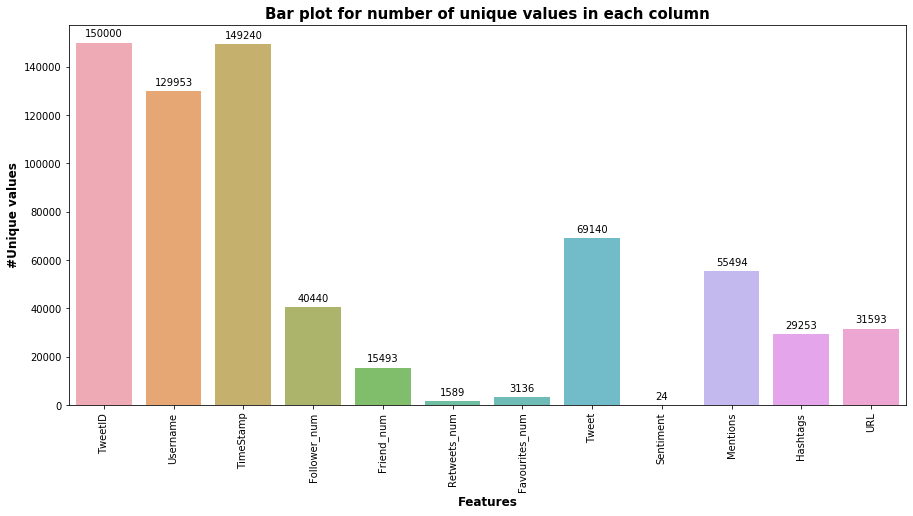

In [6]:
unique_df = pd.DataFrame()
unique_df['Features'] = df.columns
unique=[]
for i in df.columns:
    unique.append(df[i].nunique())
unique_df['Uniques'] = unique

f, ax = plt.subplots(1,1, figsize=(15,7))

splot = sns.barplot(x=unique_df['Features'], y=unique_df['Uniques'], alpha=0.8)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Bar plot for number of unique values in each column',weight='bold', size=15)
plt.ylabel('#Unique values', size=12, weight='bold')
plt.xlabel('Features', size=12, weight='bold')
plt.xticks(rotation=90)
plt.show()

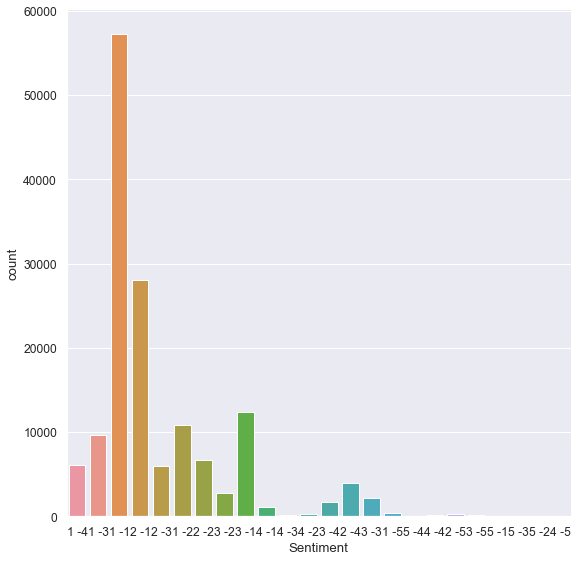

In [7]:
sns.set(font_scale=1.1)
sns.catplot("Sentiment", data=df, kind="count", height=8)

In [8]:
df = df.dropna()
"""blanks=[]
for i,user,time,a,b,c,d,tweet,senti,m,h,u,tw in df.itertuples():  # iterate over the DataFrame
    if type(tweet)==str:            # avoid NaN values
        if tweet=='null;' or user=='null;' or time=='null;' or senti=='null;' or tw=='null;':         # test 'review' for whitespace
            blanks.append(i)     # add matching index numbers to the list

df.drop(blanks, inplace=True)"""
indexNames = df[ df['Tweet'] == "null;" ].index
df.drop(indexNames , inplace=True)
df.shape

(103469, 12)

In [9]:
# write function for removing @user
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

In [10]:
# create new column with removed @user
df['Tweet_1'] = np.vectorize(remove_pattern)(df['Tweet'], '@[\w]*')

In [11]:
import re
df['Tweet_1'] = df['Tweet_1'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

In [12]:
df.head()

,TweetID,Username,TimeStamp,Follower_num,Friend_num,Retweets_num,Favourites_num,Tweet,Sentiment,Mentions,Hashtags,URL,Tweet_1
2,1278708694390173696,43250c612d875e4b4723f8bc9267f4e4,Thu Jul 02 15:14:44 +0000 2020,4018,4357,0,0,claw back:Clawback:-2.8650884132444534;,1 -1,null;,null;,https://www.wsj.com/articles/businesses-hit-hard-by-coronavirus-claw-back-jobs-11593701503:-:,claw back:Clawback:-2.8650884132444534;
3,1321386099785293824,47274922378102842a9d0d3864a9f732,Wed Oct 28 09:39:31 +0000 2020,744,732,9,17,where i live:Where_I_Live:-2.284433538491413;,1 -3,confidencenac,null;,null;,where i live:Where_I_Live:-2.284433538491413;
4,1296079483523522568,a66b8dc9de405ca8dd7616b74de4c3f8,Wed Aug 19 13:40:03 +0000 2020,15694,30,2,5,tu quoque:Tu_quoque:-1.1387633458589146;,2 -1,null;,null;,null;,tu quoque:Tu_quoque:-1.1387633458589146;
5,1301818407663423488,ebdb58380ad9b8e6e5d7ecf5eaa8ee03,Fri Sep 04 09:44:29 +0000 2020,450,999,0,0,sarkodie:Sarkodie_%28rapper%29:-1.1956325943852322;eno barony:Eno_Barony:-1.9535723834024339;rapper:Rapping:-2.468277456687856;,2 -1,andydosty eno_barony sarkodie AmgMedikal ponobiom MrLogicMusic wendyshaygh,DayBreakHitz EnoughIsEnough,null;,sarkodie:Sarkodie_%28rapper%29:-1.1956325943852322;eno barony:Eno_Barony:-1.9535723834024339;rapper:Rapping:-2.468277456687856;
6,1321907823593349125,90a76e8b91e9f9fd6280c02ddfbe455f,Thu Oct 29 20:12:39 +0000 2020,184,511,0,0,kidding:Kidding:-2.9308236049363066;,2 -3,ZawAndy,null;,https://twitter.com/ZawAndy/status/1321201463545204737?s=20:-:,kidding:Kidding:-2.9308236049363066;


In [13]:
# remove special characters, numbers, punctuations
df['Tweet_1'] = df['Tweet_1'].str.replace('[^a-zA-Z#]+',' ')

In [14]:
# remove short words
df['Tweet_1'] = df['Tweet_1'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

In [15]:
# create new variable tokenized tweet 
tokenized_tweet = df['Tweet_1'].apply(lambda x: x.split())

In [16]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

# apply stemmer for tokenized_tweet
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

In [17]:
df['Tweet_1']  = tokenized_tweet

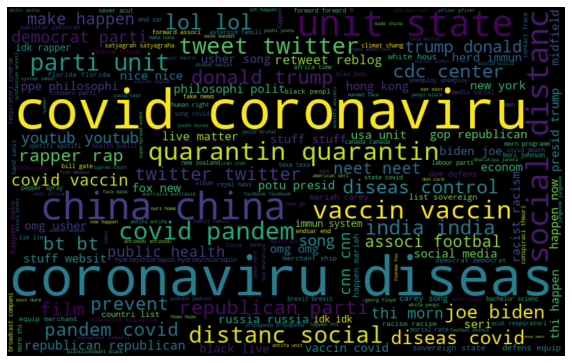

In [18]:
# create text from all tweets
all_words = ""
for i in df['Tweet_1']:
    all_words += ' '.join(i) + " "

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [19]:
df['score']  = df['Sentiment'].apply(lambda s:  s.split())
df['score'] = df['score'].apply(lambda x :int(x[0])+int(x[1]))

df['label'] = df['score'].apply(lambda c: 'positive' if c >0 else ('neutral' if c==0 else 'negative'))

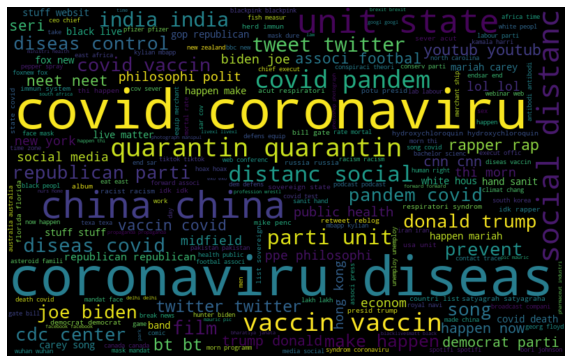

In [20]:
# create text from just normal tweets
normal_words = ""
df_1 = df[df['label']=="neutral"]
for i in df_1['Tweet_1']:
    normal_words += ' '.join(i) + " "

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

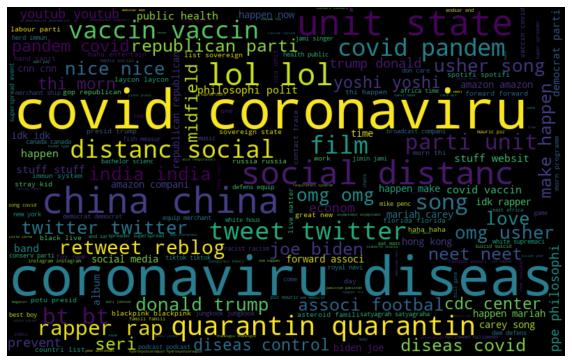

In [21]:
# create text from just normal tweets
pos_words = ""
df_1 = df[df['label']=="positive"]
for i in df_1['Tweet_1']:
    pos_words += ' '.join(i) + " "

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

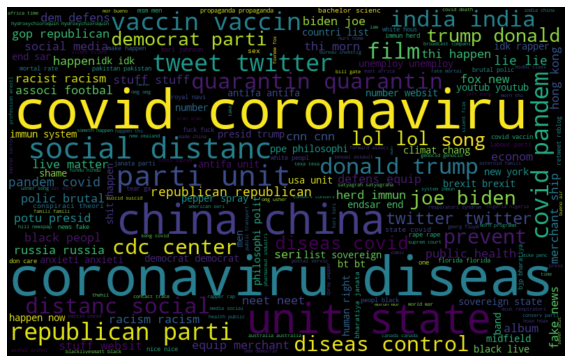

In [22]:
# create text from just normal tweets
neg_words = ""
df_1 = df[df['label']=="negative"]
for i in df_1['Tweet_1']:
    neg_words += ' '.join(i) + " "

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neg_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [23]:
df2 = df[df['Hashtags']!="null;"]

In [24]:
print("Length:", len(df2[df2['label'] == 'positive'].Hashtags))
df2[df2['label'] == 'positive'].Hashtags

Length: 10044


5                                                                                                                                    DayBreakHitz EnoughIsEnough
23                                                                                                                                      Mechaniccup CouchPeloton
24                                                                                                                       covid geography brazil geographyteacher
32                                                                                                                                        SlowtheSpread COVID19.
58                                                                                                                                       BBNaija BBNaijaLockdown
86                                                                                                                                                      COVID19,
94                                

In [25]:
print("Length:", len(df2[df2['label'] == 'negative'].Hashtags))
df2[df2['label'] == 'negative'].Hashtags

Length: 7162


11                                                                                                           این_آر_او_کے_سوالی
59                                                                                         Israel COVID19 Jerusalem Netanyahu's
97                        freetrial nlg excel powerbi alexa qlik resultsbi uipath tibco tableau cpa ai microstrategy covid19 bi
189       TheXFiles ReopeningTheXFiles podcast covid podcastseries movies funny podcastjunkie interview repost podcastcommunity
250                                                                                                    Allah_DidntAllow_Qurbani
261                                                                                                                  cashmaster
284                                                                                                                    covid19?
399                                                                                                     

In [26]:
print("Length:", len(df2[df2['label'] == 'neutral'].Hashtags))
df2[df2['label'] == 'neutral'].Hashtags

Length: 12047


8                                                                                                                            MalaysianWeCanDoIt MalaysiaCovid19
38                                                                                                               IndiaFightsCorona: VandeBharatMission StaySafe
46                                                                                                                                        COVID19 work SmallBiz
83                                                      heart covid_19 streetart emergency crigrandate crocerossaitaliana crocerossa redcross ems emt paramedic
91                                                                                                                                                      COVID19
98                                                                                                                                               ableg buylocal
104                                     

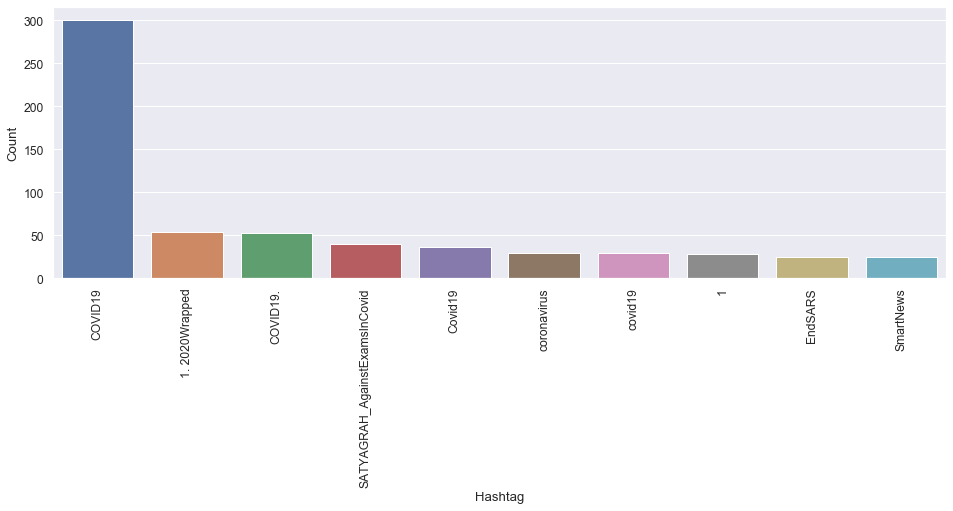

In [27]:
# making frequency distribution top 10 Positive hashtags
a = nltk.FreqDist(df2[df2['label'] == 'positive'].Hashtags)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 10)

plt.figure(figsize = (16,5))
ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count')
plt.xticks(rotation=90)
plt.show()

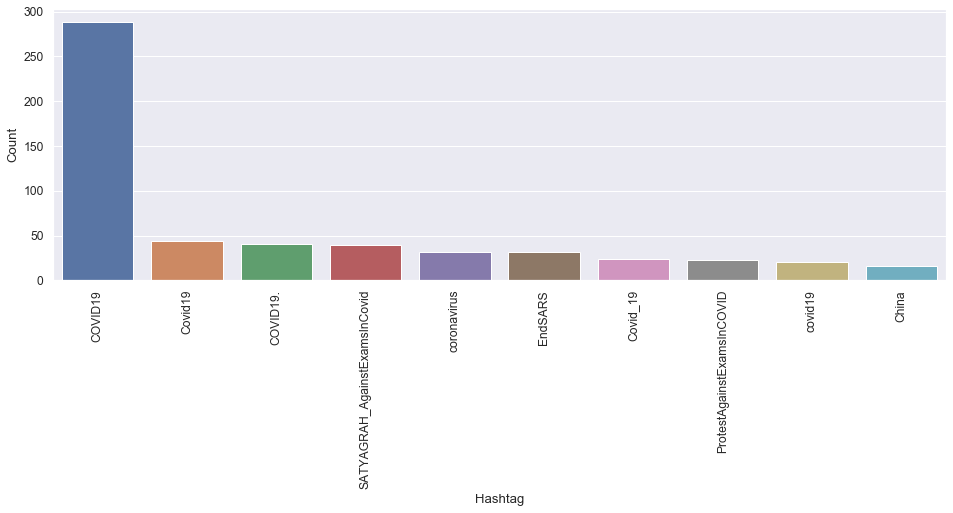

In [28]:
# making frequency distribution top 10 Negative hashtags
a = nltk.FreqDist(df2[df2['label'] == 'negative'].Hashtags)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 10)

plt.figure(figsize = (16,5))
ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count')
plt.xticks(rotation=90)
plt.show()

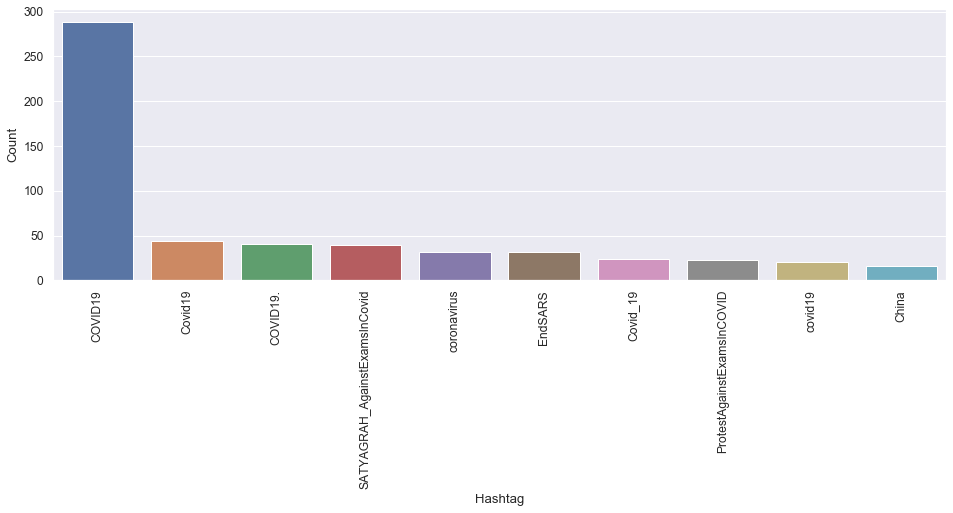

In [29]:
# making frequency distribution top 10 Neutral hashtags
a = nltk.FreqDist(df2[df2['label'] == 'negative'].Hashtags)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count' : list(a.values())})

d = d.nlargest(columns = 'Count', n = 10)

plt.figure(figsize = (16,5))
ax = sns.barplot(data =d, x = 'Hashtag', y = 'Count')
plt.xticks(rotation=90)
plt.show()

In [30]:
df3 = df[['Tweet_1', 'label']]

In [31]:
df3['Tweet_1'] = df3['Tweet_1'].apply(lambda x: ' '.join(x))

In [32]:
df['label'].value_counts()

neutral     43266
positive    31864
negative    28339
Name: label, dtype: int64

In [33]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\meena\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [35]:
df3['Tweet_1'].apply(lambda x: [item for item in x if item not in stop])

2                                                                                                                                                                      [c, l, w,  , b, c, k,  , c, l, w, b, c, k]
3                                                                                                                                                       [w, h, e, r, e,  , l, v, e,  , w, h, e, r, e,  , l, v, e]
4                                                                                                                                                                                     [q, u, q, u,  , q, u, q, u]
5                                                                                                          [r, k,  , r, k,  , r, p, p, e, r,  , e, n,  , b, r, n,  , e, n,  , b, r, n,  , r, p, p, e, r,  , r, p]
6                                                                                                                                                               

In [36]:
df3.head()

,Tweet_1,label
2,claw back clawback,neutral
3,where live where live,negative
4,quoqu quoqu,positive
5,sarkodi sarkodi rapper eno baroni eno baroni rapper rap,positive
6,kid kid,negative


In [37]:
df3.shape

(103469, 2)

In [38]:
df3.isnull().sum()

Tweet_1    0
label      0
dtype: int64

In [39]:
from sklearn.model_selection import train_test_split

train,valid = train_test_split(df3,test_size = 0.2,random_state=0,stratify = df3.label.values) #stratification means that the train_test_split method returns training and test subsets that have the same proportions of class labels as the input dataset.
print("train shape : ", train.shape)
print("valid shape : ", valid.shape)

train shape :  (82775, 2)
valid shape :  (20694, 2)


In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))
vectorizer = CountVectorizer(decode_error = 'replace',stop_words = stop)

X_train = vectorizer.fit_transform(train.Tweet_1.values)
X_valid = vectorizer.transform(valid.Tweet_1.values)

y_train = train.label.values
y_valid = valid.label.values

print("X_train.shape : ", X_train.shape)
print("X_train.shape : ", X_valid.shape)
print("y_train.shape : ", y_train.shape)
print("y_valid.shape : ", y_valid.shape)

X_train.shape :  (82775, 27424)
X_train.shape :  (20694, 27424)
y_train.shape :  (82775,)
y_valid.shape :  (20694,)


In [41]:
from sklearn.naive_bayes import MultinomialNB

naiveByes_clf = MultinomialNB()

naiveByes_clf.fit(X_train,y_train)

NB_prediction = naiveByes_clf.predict(X_valid)
NB_accuracy = accuracy_score(y_valid,NB_prediction)
print("training accuracy Score    : ",naiveByes_clf.score(X_train,y_train))
print("Validation accuracy Score : ",NB_accuracy )
print(classification_report(NB_prediction,y_valid))

training accuracy Score    :  0.5938024765931743
Validation accuracy Score :  0.45143519860829223
              precision    recall  f1-score   support

    negative       0.38      0.41      0.39      5205
     neutral       0.56      0.48      0.52     10151
    positive       0.37      0.44      0.40      5338

    accuracy                           0.45     20694
   macro avg       0.44      0.44      0.44     20694
weighted avg       0.47      0.45      0.46     20694



In [42]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()

rf_clf.fit(X_train,y_train)

rf_prediction = rf_clf.predict(X_valid)
rf_accuracy = accuracy_score(y_valid,rf_prediction)
print("Training accuracy Score    : ",rf_clf.score(X_train,y_train))
print("Validation accuracy Score : ",rf_accuracy )
print(classification_report(rf_prediction,y_valid))

Training accuracy Score    :  0.8234249471458773
Validation accuracy Score :  0.44868077703682224
              precision    recall  f1-score   support

    negative       0.31      0.41      0.36      4316
     neutral       0.63      0.47      0.54     11630
    positive       0.32      0.43      0.37      4748

    accuracy                           0.45     20694
   macro avg       0.42      0.44      0.42     20694
weighted avg       0.49      0.45      0.46     20694



In [43]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

logreg_prediction = logreg.predict(X_valid)
logreg_accuracy = accuracy_score(y_valid,logreg_prediction)
print("Training accuracy Score    : ",logreg.score(X_train,y_train))
print("Validation accuracy Score : ",logreg_accuracy )
print(classification_report(logreg_prediction,y_valid))

Training accuracy Score    :  0.6442645726366657
Validation accuracy Score :  0.4601333719918817
              precision    recall  f1-score   support

    negative       0.28      0.44      0.34      3596
     neutral       0.68      0.47      0.56     12646
    positive       0.32      0.45      0.37      4452

    accuracy                           0.46     20694
   macro avg       0.43      0.45      0.42     20694
weighted avg       0.53      0.46      0.48     20694



In [44]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [45]:
from catboost import CatBoostClassifier
clf2 = CatBoostClassifier()


clf2.fit(X_train, y_train,  
        eval_set=(X_valid, y_valid), 
        verbose=False
)

print('CatBoost model is fitted: ' + str(clf2.is_fitted()))
print('CatBoost model parameters:')
print(clf2.get_params())

CatBoost model is fitted: True
CatBoost model parameters:
{}


In [46]:
catboost_prediction = clf2.predict(X_valid)
catboost_accuracy = accuracy_score(y_valid,catboost_prediction)
print("Training accuracy Score    : ",clf2.score(X_train,y_train))
print("Validation accuracy Score : ",catboost_accuracy )
print(classification_report(catboost_prediction,y_valid))

Training accuracy Score    :  0.5012382965871338
Validation accuracy Score :  0.4784961824683483
              precision    recall  f1-score   support

    negative       0.17      0.59      0.26      1613
     neutral       0.90      0.45      0.60     17209
    positive       0.18      0.61      0.28      1872

    accuracy                           0.48     20694
   macro avg       0.42      0.55      0.38     20694
weighted avg       0.78      0.48      0.55     20694



In [47]:
#takes huge amount of time to execute
import xgboost as xgb

xgboost_clf = xgb.XGBClassifier()

xgboost_clf.fit(X_train, y_train)

xgb_prediction = xgboost_clf.predict(X_valid)
xgb_accuracy = accuracy_score(y_valid,xgb_prediction)
print("Training accuracy Score    : ",xgboost_clf.score(X_train,y_train))
print("Validation accuracy Score : ",xgb_accuracy )
print(classification_report(xgb_prediction,y_valid))

[17:20:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training accuracy Score    :  0.4989429175475687
Validation accuracy Score :  0.4757417608968783
              precision    recall  f1-score   support

    negative       0.14      0.63      0.23      1262
     neutral       0.92      0.45      0.61     17741
    positive       0.17      0.62      0.26      1691

    accuracy                           0.48     20694
   macro avg       0.41      0.57      0.37     20694
weighted avg       0.81      0.48      0.55     20694



In [48]:
from sklearn.svm import SVC

svc = SVC()

svc.fit(X_train, y_train)

svc_prediction = svc.predict(X_valid)
svc_accuracy = accuracy_score(y_valid,svc_prediction)
print("Training accuracy Score    : ",svc.score(X_train,y_train))
print("Validation accuracy Score : ",svc_accuracy )
print(classification_report(svc_prediction,y_valid))

Training accuracy Score    :  0.4181576562971912
Validation accuracy Score :  0.41814052382333045
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         0
     neutral       1.00      0.42      0.59     20694
    positive       0.00      0.00      0.00         0

    accuracy                           0.42     20694
   macro avg       0.33      0.14      0.20     20694
weighted avg       1.00      0.42      0.59     20694



In [50]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss = 'hinge', penalty = 'l2', random_state=0)

sgd_clf.fit(X_train,y_train)

sgd_prediction = sgd_clf.predict(X_valid)
sgd_accuracy = accuracy_score(y_valid,sgd_prediction)
print("Training accuracy Score    : ",sgd_clf.score(X_train,y_train))
print("Validation accuracy Score : ",sgd_accuracy )
print(classification_report(sgd_prediction,y_valid))

Training accuracy Score    :  0.6160434913923286
Validation accuracy Score :  0.46520730646564223
              precision    recall  f1-score   support

    negative       0.27      0.46      0.34      3290
     neutral       0.72      0.47      0.57     13346
    positive       0.30      0.47      0.36      4058

    accuracy                           0.47     20694
   macro avg       0.43      0.46      0.42     20694
weighted avg       0.56      0.47      0.49     20694



In [51]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 
              'Stochastic Gradient Decent', 'XGBoost','CatBoost'],
    'Test accuracy': [svc_accuracy, logreg_accuracy, 
              rf_accuracy, NB_accuracy, 
              sgd_accuracy, xgb_accuracy,catboost_accuracy]})

models.sort_values(by='Test accuracy', ascending=False)

,Model,Test accuracy
6,CatBoost,0.478496
5,XGBoost,0.475742
4,Stochastic Gradient Decent,0.465207
1,Logistic Regression,0.460133
3,Naive Bayes,0.451435
2,Random Forest,0.448681
0,Support Vector Machines,0.418141
